### Previsão de Mortes Neonatal

Neste projeto, vamos utilizar dados públicos do SINASC (Sistema de Nascidos Vivos) e do SIM (Sistema de Mortalidade) para construir modelos de aprendizado de máquina capazes de prever o risco de morte neonatal (até 28 dias após o nascimento).

*Alunos:*
- Júlia Moraes
- Luiz Eduardo

Imports necessários

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score


#### 1. Tratamentos básico dos dados para o Aprendizado

##### 1.1 Construindo matriz X e vetor y

In [2]:
df = pd.read_csv('sinasc_balanceado.csv', low_memory=False)

In [4]:
# dados númericos
num_cols = ['idade_mae', 'peso', 'semanas_gestacao', 'num_gestacao',
            'partos_normais', 'partos_cesareos', 'mes_inicio_prenatal', 'qntd_filvivos', 'qntd_filmortos']

# dados ordinais
ord_cols = ['consultas_prenatal', 'indice_kotelchuck', 'escolaridade_mae']

# dados categóricos
cat_cols = ['tipo_gravidez', 'tipo_parto', 'parto_induzido', 'cesarea_antes',
            'racacor_mae', 'racacor_bebe', 'paridade', 'anomalia_identificada',
            'doenca_epidemiologicas', 'doenca_nova',
            'prenatal_inadequado', 'poucas_consultas', 'prenatal_tardio']

In [7]:
# Transformar 9 ou outros ignorados em NaN
df.replace(9, pd.NA, inplace=True)

In [6]:
#Pipeline de pré-processamento

# Numéricas: imputar média e padronizar
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # valores vazios vira média
    ('scaler', StandardScaler()) # normaliza
])

# Ordinais: imputar mais frequente e codificar como dummies
ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
])

# Categóricas: imputar mais frequente e codificar dummies
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # valores vazios vira moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # codifica dummies
]) # exemplo: tipo_parto_vaginal, tipo_parto_cesarea recebe 0 ou 1 

# Combinar
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ord', ord_transformer, ord_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [8]:
y = df['obitos_1m']
X = df.drop(columns=['obitos_1m'])

In [9]:
# Verificar valores nulos nas colunas numéricas
print("Valores nulos nas colunas numéricas:")
for col in num_cols:
    if col in X.columns:
        print(f"{col}: {X[col].isnull().sum()}")

# Substituir pd.NA por np.nan para compatibilidade com sklearn
X = X.replace({pd.NA: np.nan})

Valores nulos nas colunas numéricas:
idade_mae: 2
peso: 29
semanas_gestacao: 585
num_gestacao: 1621
partos_normais: 2214
partos_cesareos: 2237
mes_inicio_prenatal: 2220
qntd_filvivos: 1714
qntd_filmortos: 2432


C:\Users\julja\AppData\Local\Temp\ipykernel_7596\1250505372.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({pd.NA: np.nan})


In [10]:
X_processed = preprocessor.fit_transform(X)

##### 1.2 Número de amostras e parametros 

In [17]:
N, p = X_processed.shape

print(f"Número de amostras (N): {N}")
print(f"Número de parâmetros (p): {p}")

Número de amostras (N): 44958
Número de parâmetros (p): 46


##### 1.3 Separar em treino e teste

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### 2. REDES NEURAIS

##### 2.1 Definindo arquitetura da rede neural

Para calcularmos o número máximo de neurônios por camada fazemos a substituição na seguinte fórmula: 
𝑛 ≤ 𝐶𝑇−10/10(𝑑+2)
Substiutuindo, teremos aproximadamente 59 como limite de neurônios por camada.

In [22]:
BATCH_SIZE = 32
EPOCHS = 100
RANDOM_STATE = 2

Testando primeira rede neural

In [32]:
# Criando a arquitetura da rede neural inicial 
model = Sequential()

model.add(Dense(64, input_dim=46, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(32, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(16,kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1,kernel_initializer='he_normal', activation='sigmoid'))

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=BATCH_SIZE)

c:\Users\julja\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7304 - loss: 0.5128 - val_accuracy: 0.7724 - val_loss: 0.4591
Epoch 2/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7723 - loss: 0.4487 - val_accuracy: 0.7737 - val_loss: 0.4561
Epoch 3/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7764 - loss: 0.4411 - val_accuracy: 0.7865 - val_loss: 0.4364
Epoch 4/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7815 - loss: 0.4362 - val_accuracy: 0.7257 - val_loss: 0.6435
Epoch 5/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7842 - loss: 0.4326 - val_accuracy: 0.6832 - val_loss: 0.5864
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7837 - loss: 0.4324 - val_accuracy: 0.7195 - val_loss: 0.4999
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7869 - loss: 0.4303 - val_accuracy: 0.7373 - val_loss: 0.4801
Epoch 8/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7853 - loss: 0.4286 - val

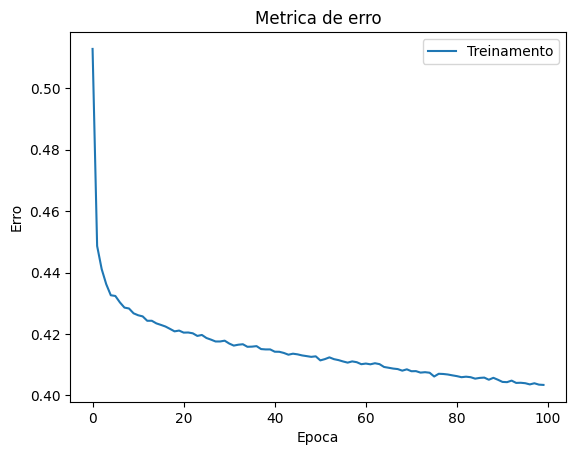


--> Acuracia (treino): 0.8098
--> Acuracia (teste): 0.7995
--> E_out - E_in = 0.0169
--> acc_train - acc_test = 0.0103


In [34]:
plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de teste
E_out, acc_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - E_in:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

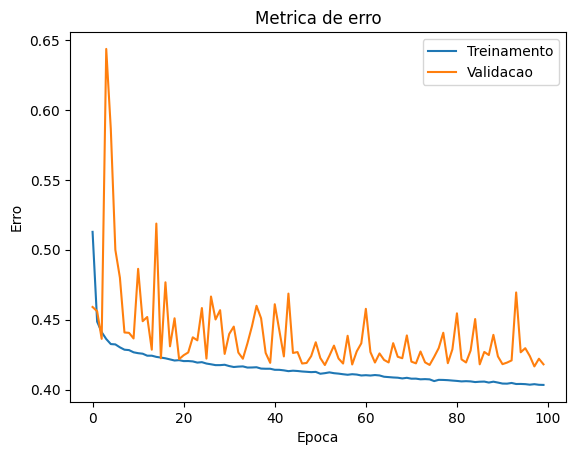

--> E_val - E_in = 0.0199
--> Acuracia (treino): 0.8098
--> Acuracia (validacao): 0.7987
--> acc_train - acc_val = 0.0111


In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

Testando segunda rede neural

In [37]:
# Criando a arquitetura da rede neural inicial 
model = Sequential()

model.add(Dense(32, input_dim=46, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

# Instanciação e configuração de otimizadores
sgd = optimizers.SGD(learning_rate=0.01)

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

c:\Users\julja\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 32)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,177 (8.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6522 - loss: 0.6531 - val_accuracy: 0.6671 - val_loss: 0.6261
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6657 - loss: 0.6301 - val_accuracy: 0.6669 - val_loss: 0.6072
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6676 - loss: 0.6019 - val_accuracy: 0.6704 - val_loss: 0.5867
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6884 - loss: 0.5471 - val_accuracy: 0.7282 - val_loss: 0.4787
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7266 - loss: 0.5059 - val_accuracy: 0.7737 - val_loss: 0.4524
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7503 - loss: 0.4911 - val_accuracy: 0.7780 - val_loss: 0.4493
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7550 - loss: 0.4832 - val_accuracy: 0.7847 - val_loss: 0.4427
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7572 - loss: 0.4764 - val

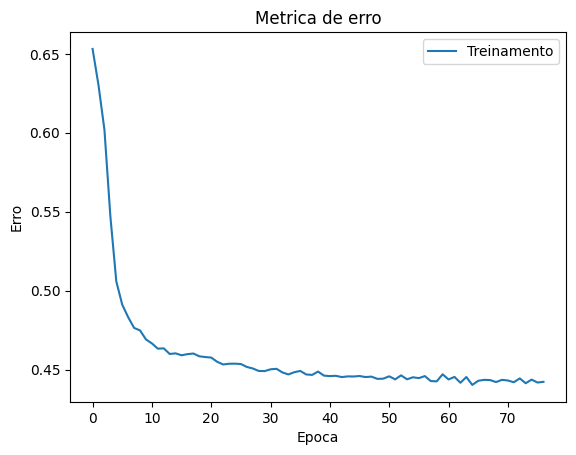


--> Acuracia (treino): 0.7916
--> Acuracia (teste): 0.7904
--> E_out - E_in = 0.0016
--> acc_train - acc_test = 0.0012


In [38]:
plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de teste
E_out, acc_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - E_in:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

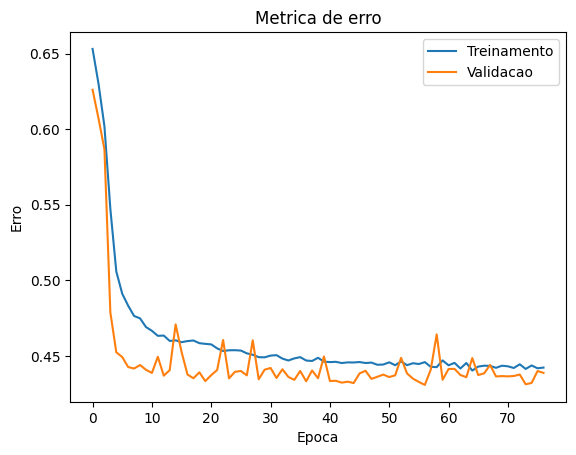

--> E_val - E_in = 0.0011
--> Acuracia (treino): 0.7916
--> Acuracia (validacao): 0.7905
--> acc_train - acc_val = 0.0011


In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

# Obtendo a acuracia no conjunto de treinamento
E_in, acc_train = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)

# Obtendo a acuracia no conjunto de validacao
E_val, acc_val = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE, verbose=0)

print(f"--> E_val - E_in = {E_val - E_in:.4f}")
print(f'--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")

Ambos os modelos estao bem ajustados, porém a superioridade na generalização do segundo modelo é mais valiosa que a pequena vantagem em acurácia do primeiro modelo.

#### 3. Árvores de decisão

##### 3.1 Construindo a árvore de decisão

In [50]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

print("Ein: %0.4f" % (1 - accuracy_score(y_train, clf.predict(X_train)) ))
print("Eout: %0.4f" % (1 - accuracy_score(y_test, clf.predict(X_test)) ))

print(classification_report(y_test, clf.predict(X_test)))

Ein: 0.0000
Eout: 0.2565
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      5976
           1       0.62      0.62      0.62      3016

    accuracy                           0.74      8992
   macro avg       0.71      0.71      0.71      8992
weighted avg       0.74      0.74      0.74      8992



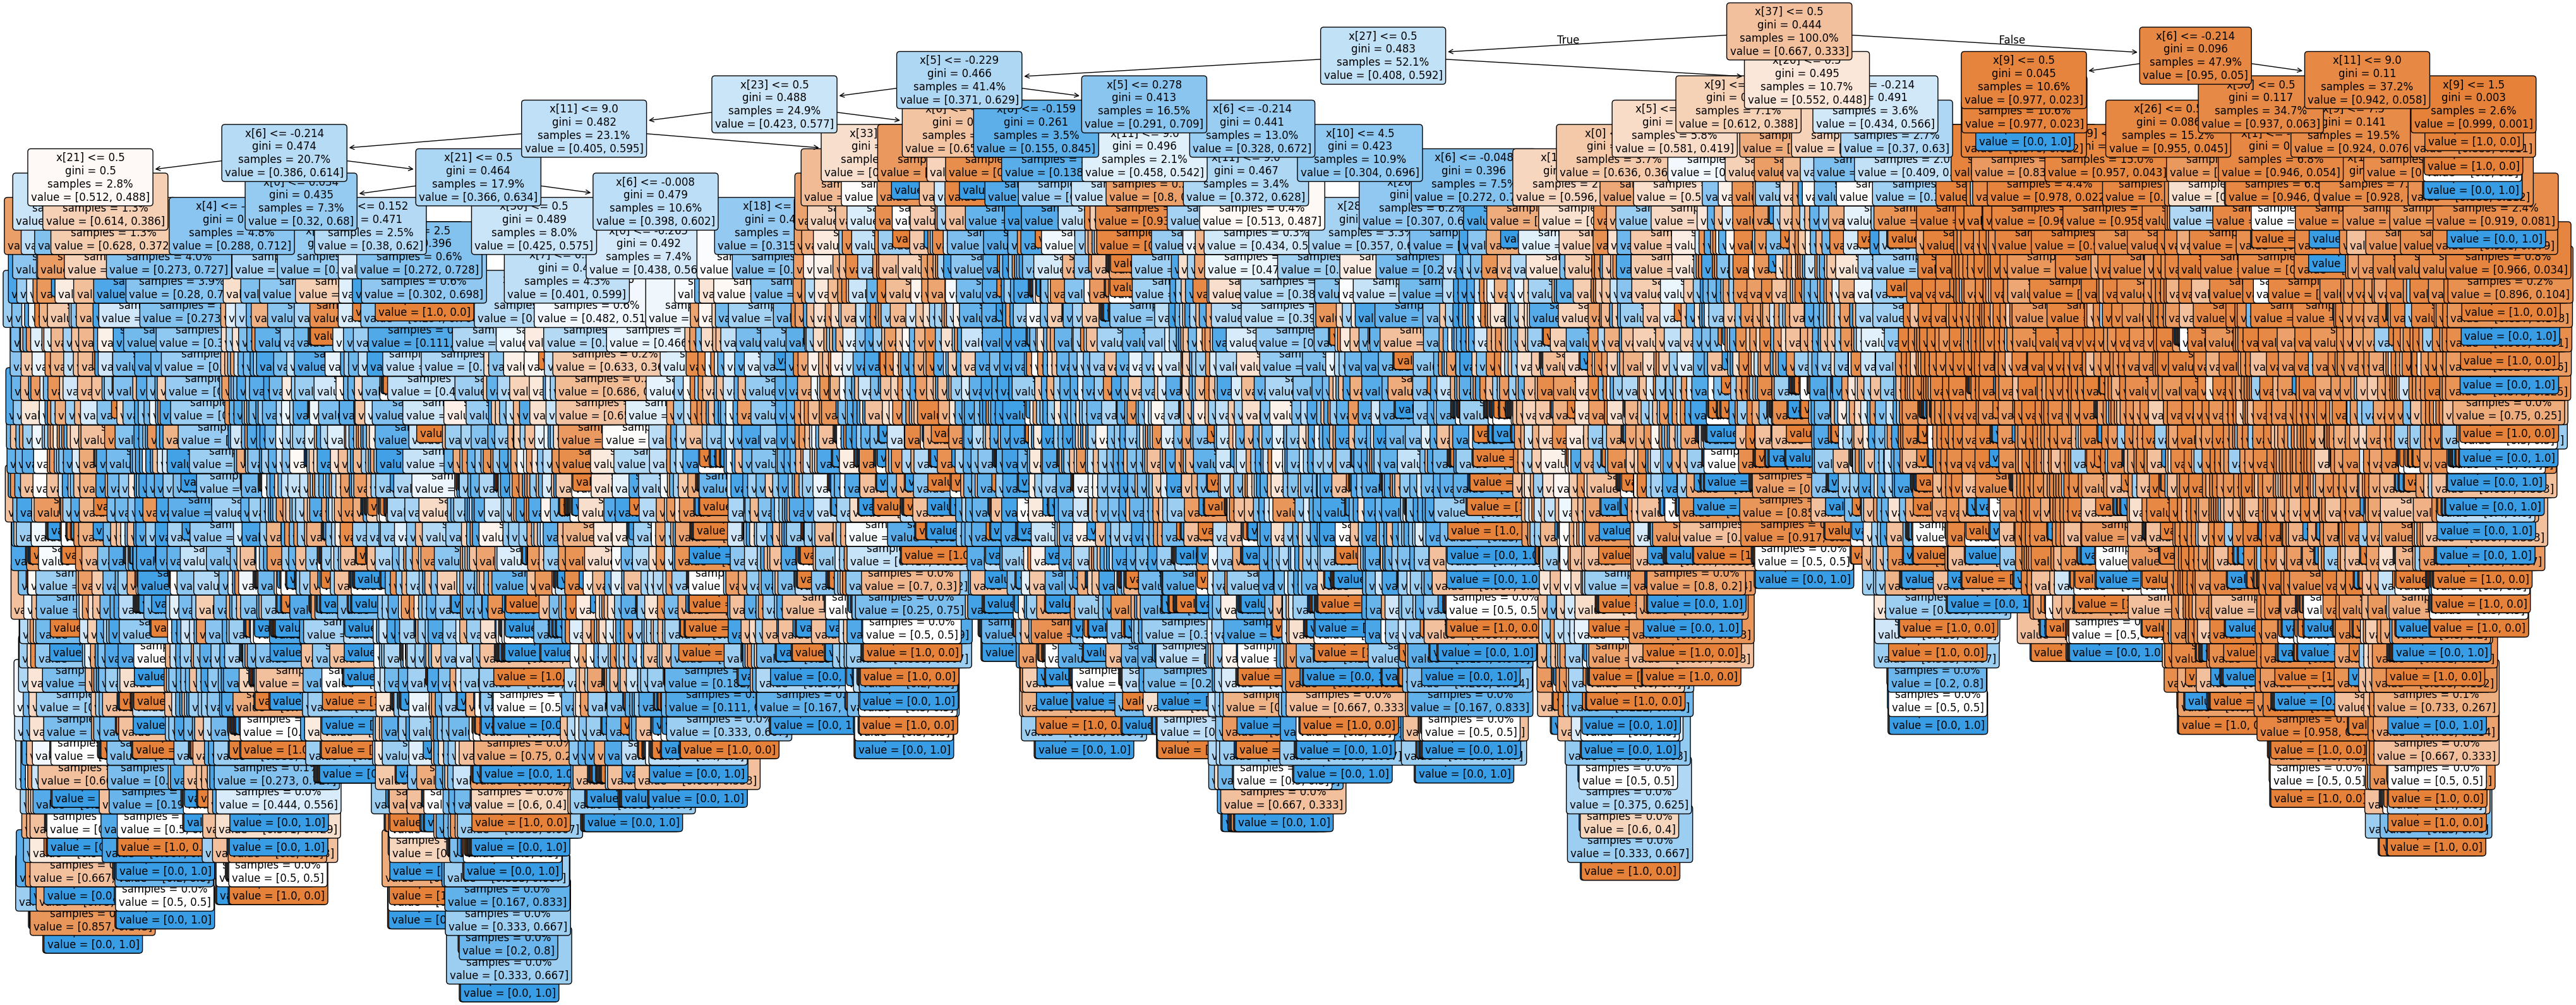

In [53]:
#Desenho da árvore
plt.figure(figsize=(50,20))
plot_tree(
    clf,
    filled=True, 
    proportion = True,
    fontsize=12, 
    rounded = True)
plt.show()

C:\Users\julja\AppData\Local\Temp\ipykernel_7596\889613658.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.00000000e+00 1.15853376e-05 1.38097224e-05 ... 3.45111550e-03
 5.61992978e-03 1.46399648e-01]
[3.47560128e-05 4.63413504e-05 1.15389962e-04 ... 2.92038018e-01
 2.97657947e-01 4.44057595e-01]


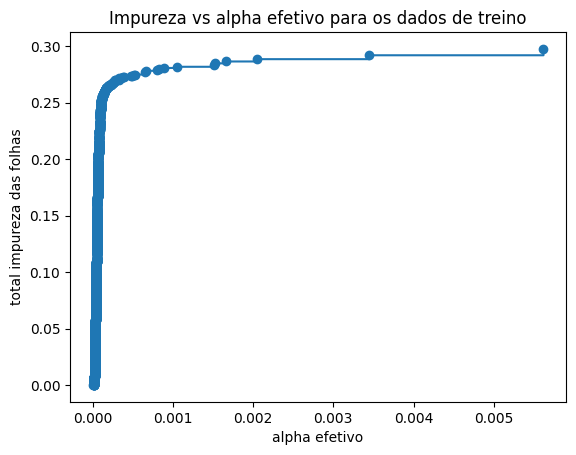

In [54]:
#Recupera os valores efetivos de alpha para a elaboração da fase de prunning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#Plota a relação entre os valores de alpha e impureza das folhas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("alpha efetivo")
ax.set_ylabel("total impureza das folhas")
ax.set_title("Impureza vs alpha efetivo para os dados de treino")
fig.show()

print(ccp_alphas)
print(impurities)

In [56]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# 6. Encontrar melhor alpha
best_alpha = ccp_alphas[clfs.index(max(clfs))]

Exception ignored in: 'zmq.backend.cython._zmq.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/_zmq.py", line 176, in zmq.backend.cython._zmq._check_rc
    PyErr_CheckSignals()
KeyboardInterrupt: 


KeyboardInterrupt: 

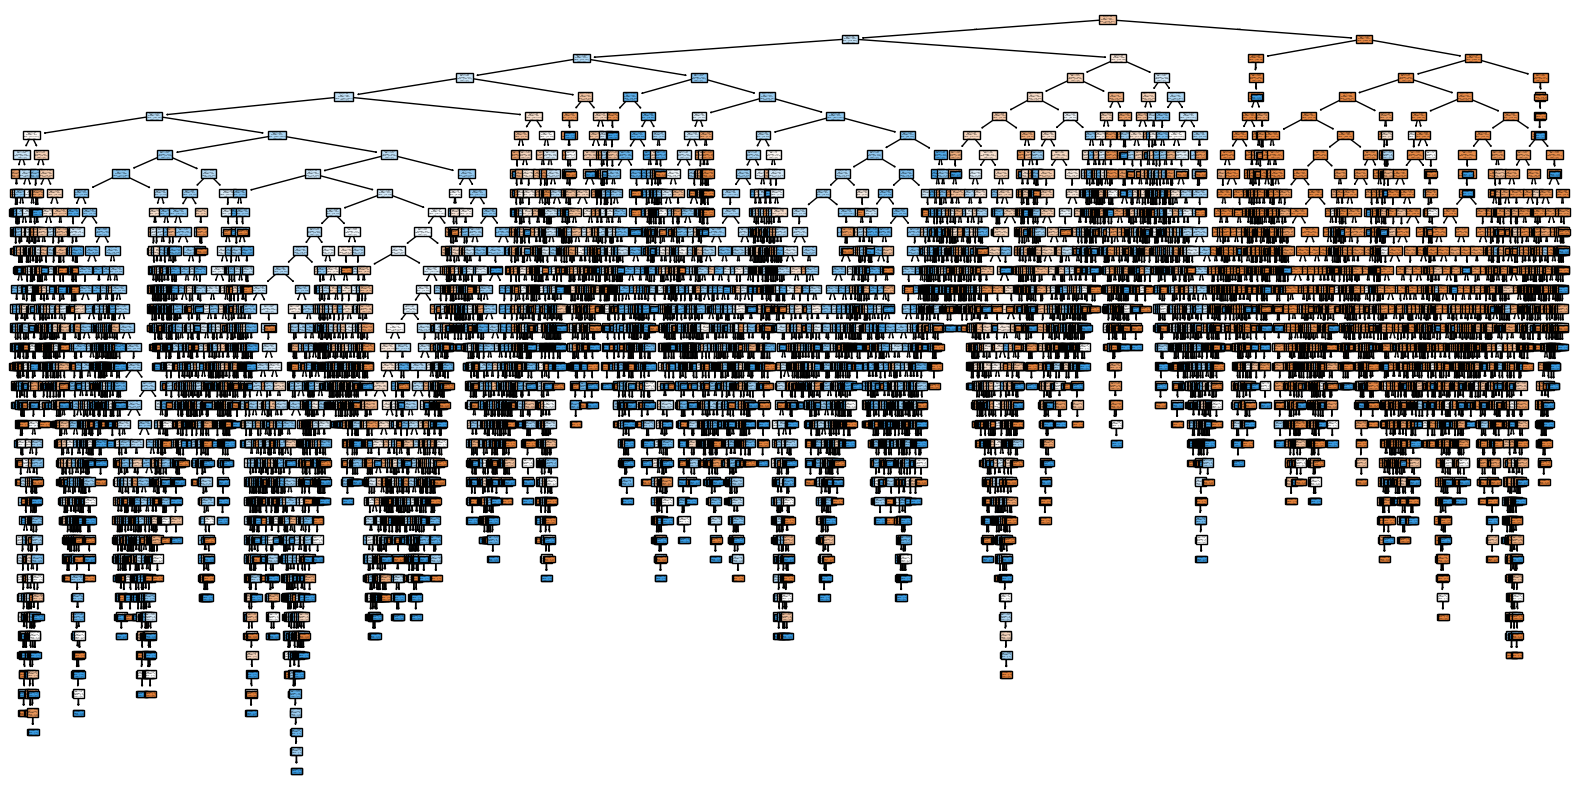

Ein: 0.0000
Eout: 0.2615


KeyboardInterrupt: 

In [ ]:
# 7. Treinar melhor árvore
best_clf = DecisionTreeClassifier(ccp_alpha=best_alpha, random_state=42)
best_clf.fit(X_train, y_train)

print('Ein: %0.4f' % (1 - accuracy_score(y_train, best_clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, best_clf.predict(X_test))))
print(classification_report(y_test, best_clf.predict(X_test)))

#Desenho da árvore
plt.figure(figsize=(50,20))
plot_tree(
    best_clf,
    filled=True, 
    proportion = True,
    fontsize=36, 
    rounded = True)
plt.show()

#### 4. SVM